### Домашнее задание "Сингулярный спектральный анализ"
Провести анализ с помощью SSA любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). Посмотрите на результаты с разными длинами окон. Обязательно визуализируйте результаты, аналогично материалу с занятия.

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# настроим параметры визуализаций
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [2]:
# Импортируем ряд из папки Series
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
F = sales_of_company_x.Count

In [3]:
#Зададим параметры 
L = 30 #длина окна
N = len(sales_of_company_x) #длина ряда
K = N - L + 1 #число столбцов в матрице траекторий

In [4]:
#создадим матрицу траекторий
X = np.column_stack([F[i:i+L] for i in range(0,K)])

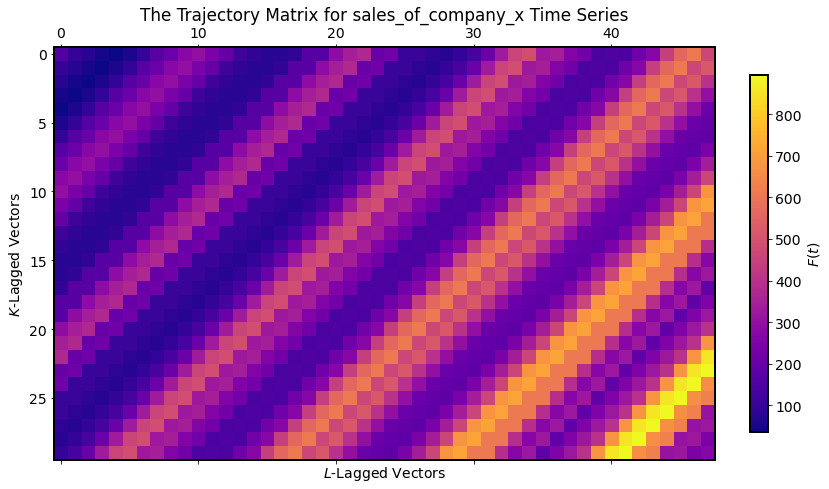

In [5]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for sales_of_company_x Time Series");

In [6]:
# разложим матрицу траекторий и сформируем ее элементарные матрицы:
d = np.linalg.matrix_rank(X) # для начала найдем ранг матрицы при помощи SVD разложения
U, Sigma, V = np.linalg.svd(X) #разложим матрицу с помощью SVD
V = V.T #транспонируем матрицу V обратно, т.к. SVD возвращает транспонированную матрицу V
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] ) #вычислим элементарные матрицы X
#проверим, насколько корректно мы разложили X:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")
else:
    print("It's ok, sanity check is good!")

It's ok, sanity check is good!


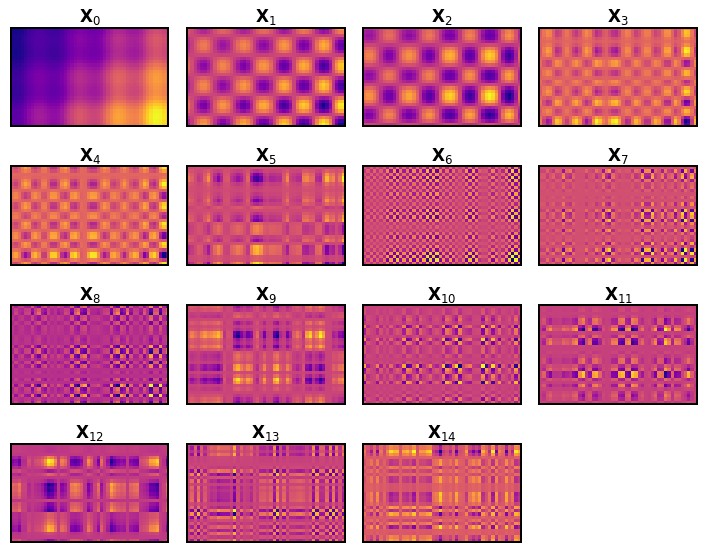

In [7]:
#Посмотрим первые 15 элементарных матриц
n = min(15, d)
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Первая матрица X0 - вероятно, трендовая составляющая, X1-X4 - вероятно, периодические компоненты.
Далее проверим наши предположения более точно, но для начала определим, сколько первых элементарных матриц вносят значительный вклад в X

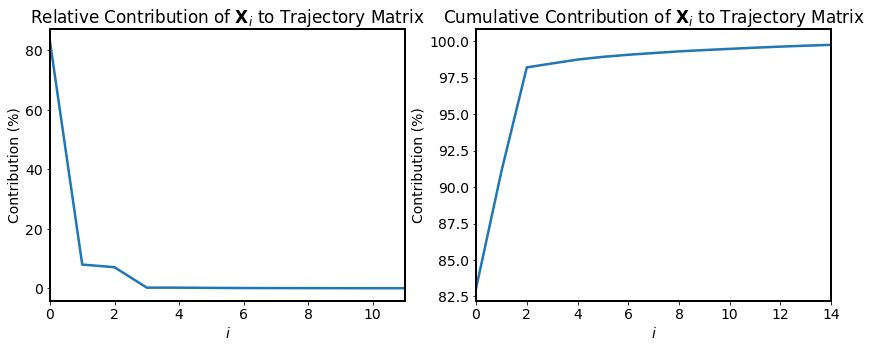

In [8]:
#построим графики относительных и накопительных вкладов элементарных матриц в X
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,14)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

Из графиков видно, что более 80% вносит X0, следующие две X1-X2 около 7,5% каждая и еще небольшой прирост дают X3-X4 (по накопительному графику), все остальное точно можно отнести к шуму
X1 и X2, равно как и X3-X4 вероятно, будут сгруппированы вместе

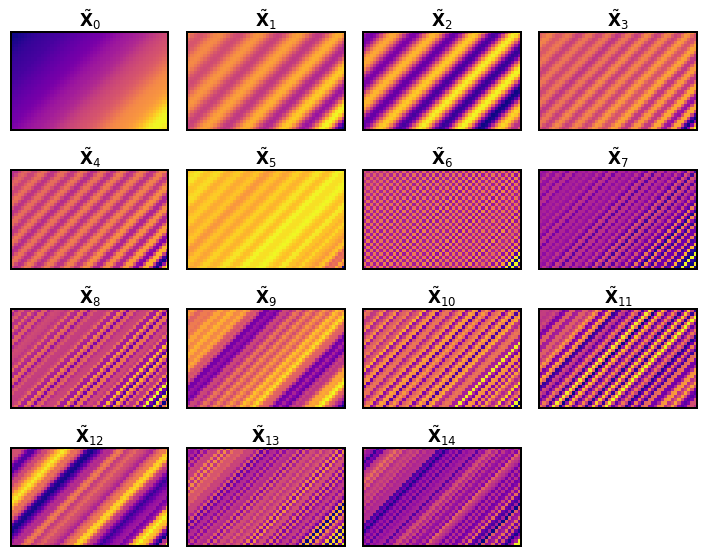

In [9]:
#теперь приступим к реконструкции нашего временного ряда
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX
    
n = min(d, 15)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

Наши подозрения насчет X1 и X2 подтвердились, вероятно, они будут сгруппированы вместе как первый периодический компонент.
X3 и X4 сгруппированы вместе, как второй периодический компонент. 

In [10]:
#вычислим реконструированные Fi непосредственно из Xi
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

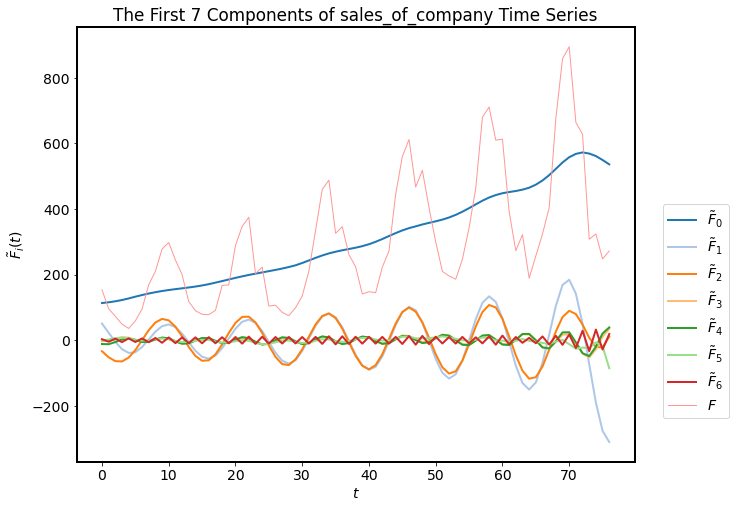

In [11]:
n = min(7,d)
t = np.arange(0,N)

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 7 Components of sales_of_company Time Series")
fig.legend(legend, loc=(1.05,0.1));

In [12]:
#видим, что F0 - возрастающий тренд, F1+F2 - собираются в первую периодическую компоненту, F3+F4 - во вторую (но с небольшой амплитудой)

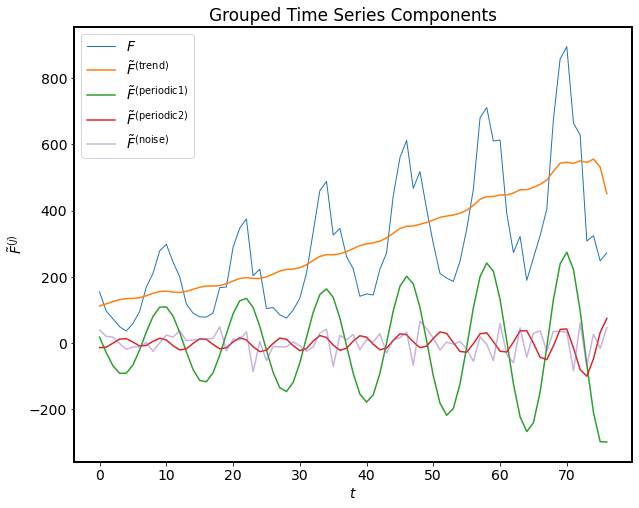

In [13]:
# Получим составляющие временного ряда за счет группировки компонент
F_trend = X_to_TS(X_elem[[0,5]].sum(axis=0)) #тренд
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0)) #периодическая составляющая  1
F_periodic2 = X_to_TS(X_elem[[3,4]].sum(axis=0)) #периодическая составляющая  2
F_noise = X_to_TS(X_elem[6:].sum(axis=0)) #шум

# Построим временной ряд и его компоненты на одном графике
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

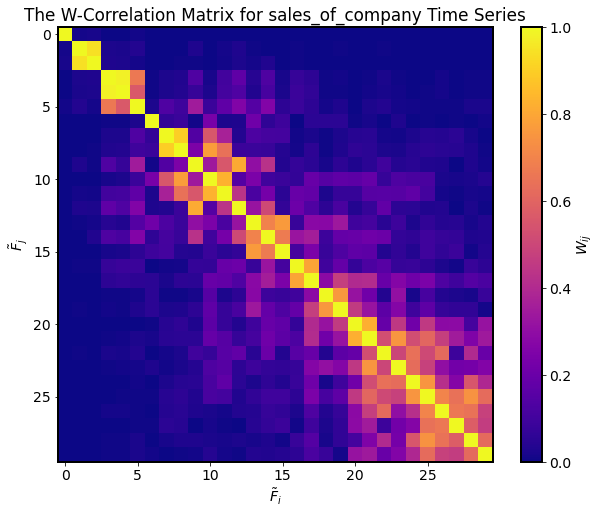

In [14]:
#построим график w-корреляционной матрицы, чтобы определить, какие компоненты, возможно, необходимо сгруппировать вместе
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]
        
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for sales_of_company Time Series");

Важно отметить,что  𝐖corr  грубо разделен на два "блока":  0≤𝑖,𝑗≤5  и  5≤,𝑗≤30 . Это соответствует двум основным группам: сглаженный временной ряд (т. е. тренд плюс две периодические компоненты) и остаточный шум. Масштабирование первых пяти компонентов в  𝐖corr :

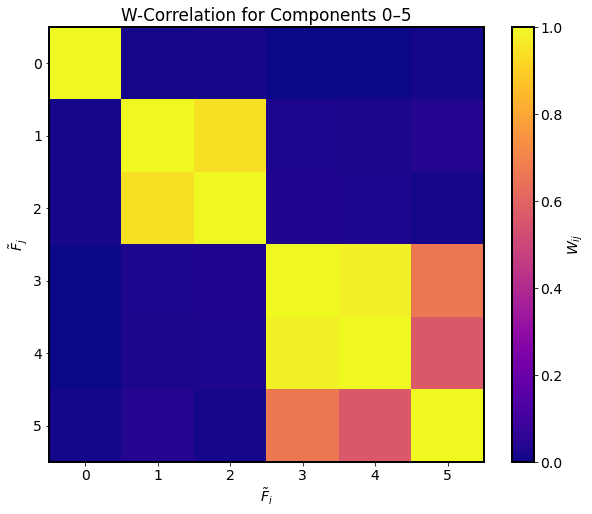

In [15]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,5.5)
plt.ylim(5.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–5");

In [16]:
# реализация при помощи класса SSA 
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

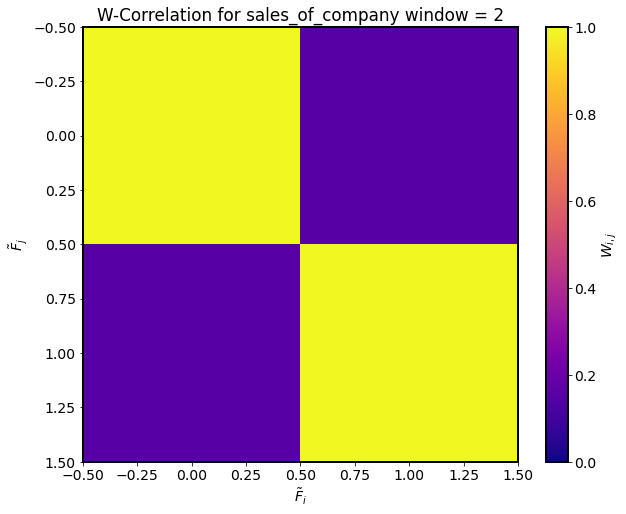

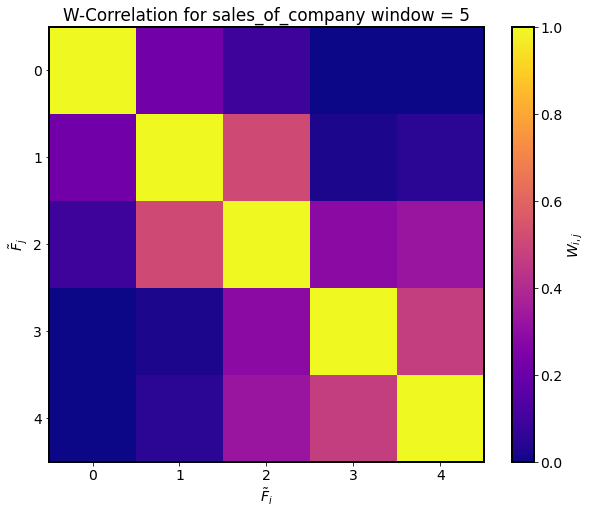

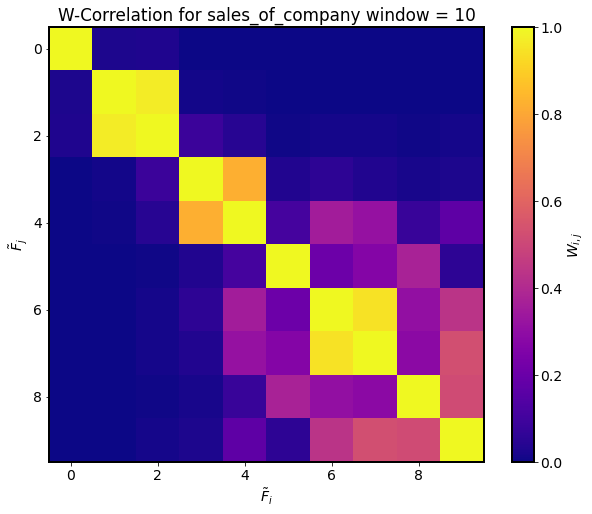

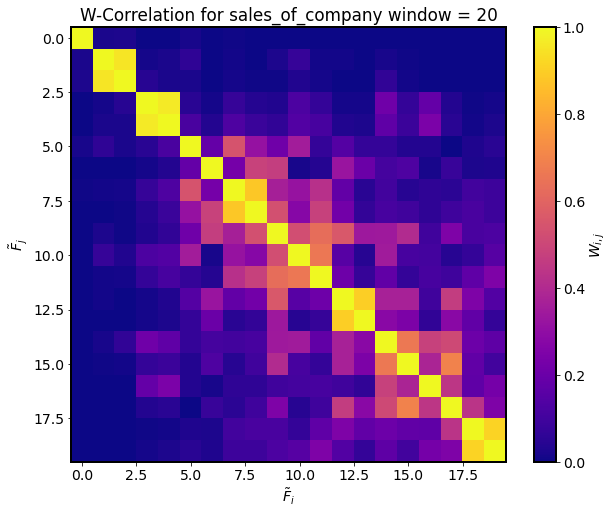

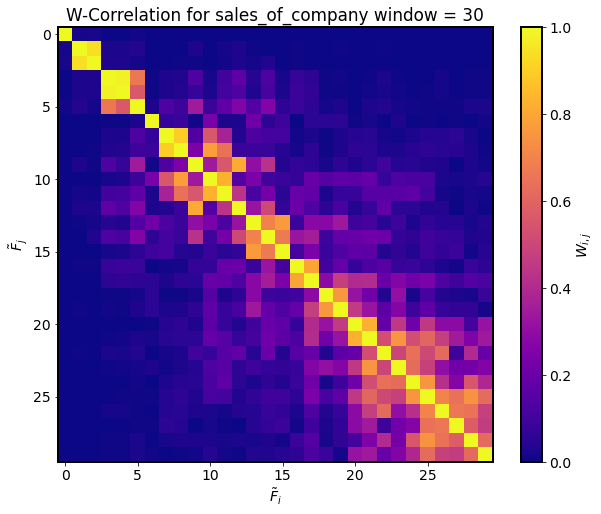

In [17]:
windows = [2,5,10,20,30] #матрицы корреляций для разных длин окон
for window in windows:
    ssa_l = SSA(F, window)
    ssa_l.plot_wcorr()
    plt.title(f"W-Correlation for sales_of_company window = {window}")
    plt.show()

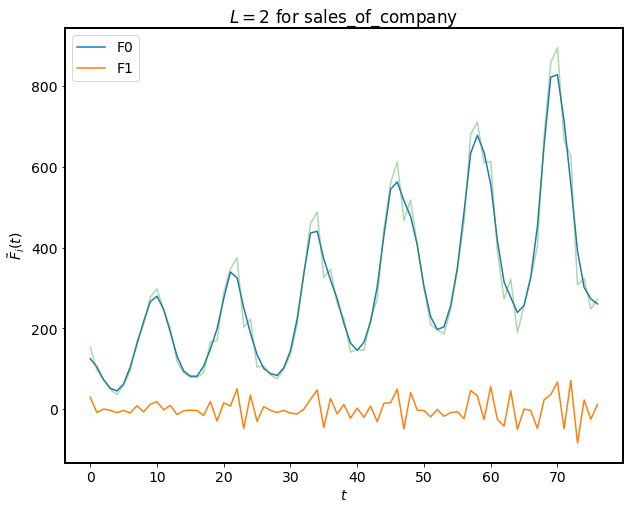

In [18]:
# L = 2
ssa_L2 = SSA(F, 2)
ssa_L2.components_to_df().plot()
ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for sales_of_company");

In [19]:
#Даже при такой небольшой длине окна алгоритм SSA начал отделять высокочастотный шум от ряда, давая нам несколько ослабленную версию исходного ряда в компоненте  𝐹̃ 0.

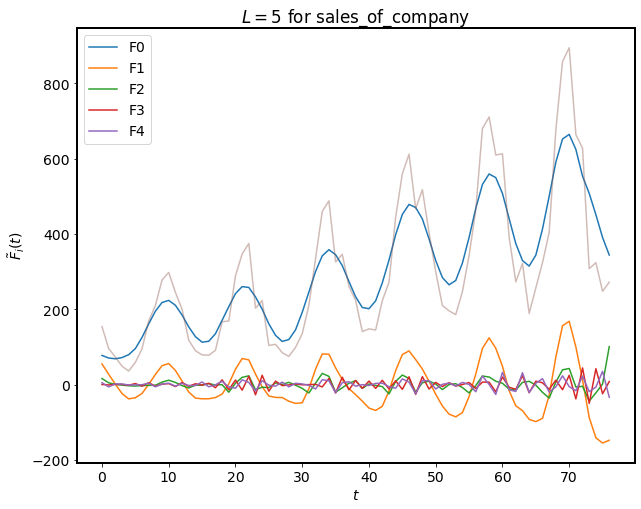

In [19]:
# L = 5
ssa_L5 = SSA(F, 5)
ssa_L5.components_to_df().plot()
ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for sales_of_company");

In [20]:
#Отделились F0, F1, F2, остальное, по-видимому, ушло в шум

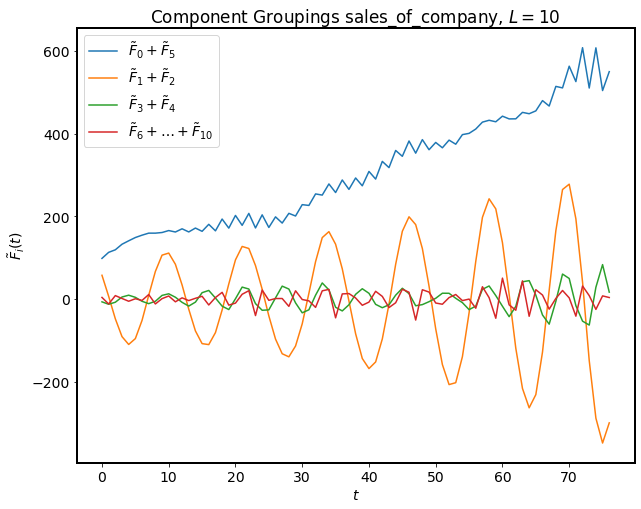

In [21]:
#Для более высоких значений окон реконструируем ряд
# L= 10
F_ssa_L10 = SSA(F, 10)
F_ssa_L10.reconstruct([0,5]).plot()
F_ssa_L10.reconstruct([1,2]).plot()
F_ssa_L10.reconstruct([3,4]).plot()
F_ssa_L10.reconstruct(slice(6,20)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings sales_of_company, $L=10$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_5$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_6+ \ldots + \tilde{F}_{10}$"]);

При  𝐿=10  мы начинаем видеть тренд и периодические компоненты начинают обретать форму. Компонент F5 вызывает беспокойство, так как выглядит так, как будто он вносит свой вклад как в шум*, так и в тренд. Это говорит о том, что нам нужно увеличить длину окна и посмотреть, получим ли мы улучшенное разделение шума и периодичности.

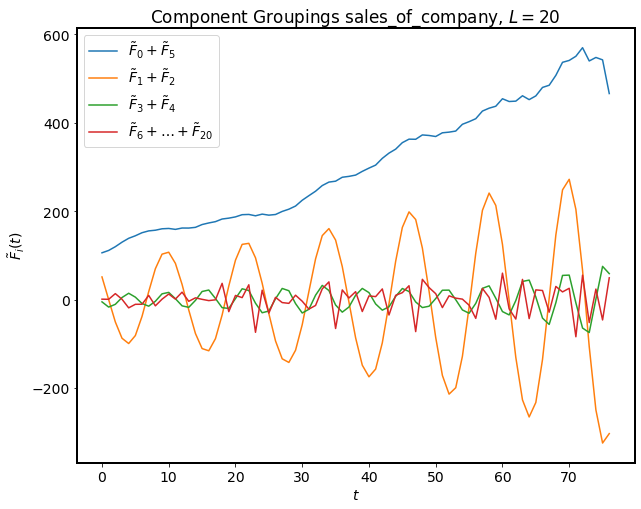

In [22]:
# L= 20
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.reconstruct([0,5]).plot()
F_ssa_L20.reconstruct([1,2]).plot()
F_ssa_L20.reconstruct([3,4]).plot()
F_ssa_L20.reconstruct(slice(6,20)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings sales_of_company, $L=20$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_5$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_6+ \ldots + \tilde{F}_{20}$"]);

In [25]:
#Видно, что и эта группировка не идеальна, увеличиваем длину окна еще

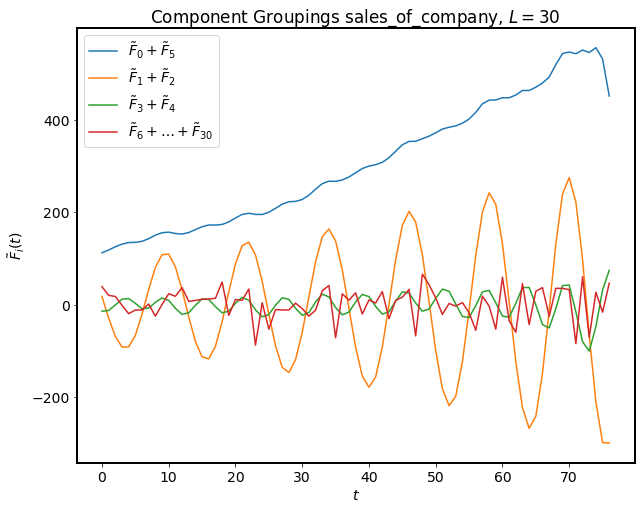

In [23]:
# L= 30
F_ssa_L30 = SSA(F, 30)
F_ssa_L30.reconstruct([0,5]).plot()
F_ssa_L30.reconstruct([1,2]).plot()
F_ssa_L30.reconstruct([3,4]).plot()
F_ssa_L30.reconstruct(slice(6,30)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings sales_of_company, $L=30$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_5$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_6+ \ldots + \tilde{F}_{30}$"]);

In [27]:
#компонент тренда стал ухудшаться, думаю, что стоит остановиться на этой длине окна
#проверим, является ли наша шумовая составляющая реально белым шумом

In [28]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [30]:
F_noise = F_ssa_L30.reconstruct(slice(6,30))

In [32]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
test_stationarity(F_noise)

Results of Dickey-Fuller Test:
Test Statistic                -1.219677e+01
p-value                        1.249401e-22
#Lags Used                     0.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64


In [33]:
#как мы видим, наш F_noise стационарен, по нашему разложению мы выделили все компоненты